# Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Split train set and test set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the sampled dataset
df=pd.read_csv('./drive/MyDrive/CICIDS2017_sample_km.csv')

In [5]:
df.head()
print(df.columns)

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [6]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(min(y),max(y))

0 6


# Feature engineering

In [7]:
features = df.dtypes[df.dtypes != 'object'].index
print(features,len(features))

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [8]:
class ReliefF:
    def __init__(self, n_neighbors=5, n_features_to_select=None):
        self.n_neighbors = n_neighbors
        self.n_features_to_select = n_features_to_select

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.feature_scores = np.zeros(self.n_features)

        for i in range(len(X)):
            distances = np.linalg.norm(X[i] - X, axis=1)
            nn_indices = np.argsort(distances)[1:self.n_neighbors + 1]
            near_hit = None
            near_misses = []
            for j in nn_indices:
                if y[j] == y[i]:
                    if near_hit is None:
                        near_hit = X[j]
                else:
                    near_misses.append(X[j])
            if near_hit is not None:
                self.feature_scores += np.abs(X[i] - near_hit)
            if len(near_misses) > 0:
                near_misses = np.array(near_misses)
                self.feature_scores -= np.abs(X[i] - near_misses.mean(axis=0))

        self.feature_scores /= len(X)

    def transform(self, X):
        if self.n_features_to_select is None:
            return X
        else:
            idx = np.argsort(self.feature_scores)[::-1][:self.n_features_to_select]
            return X[:, idx]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

reliefF = ReliefF(n_neighbors=5, n_features_to_select=60)  # Specify the number of neighbors and features to select
X_train_selected = reliefF.fit_transform(X_train, y_train)
X_test_selected = reliefF.transform(X_test)

print(X_train_selected.shape)


(21440, 60)


# Wrapper-based Feature Selection:

Genetic Algorithm for feature selection

In [9]:
# def RFE(X_train, y_train, estimator, n_features_to_select):
#     remaining_features = list(range(X_train.shape[1]))
#     selected_features = []
#     while len(selected_features) < n_features_to_select:
#         best_score = -float('inf')
#         best_feature = None
#         for feature in remaining_features:
#             current_features = selected_features + [feature]
#             # Dummy fit function for compatibility, not actually training the model
#             score = dummy_fit(X_train[:, current_features], y_train, estimator)
#             if score > best_score:
#                 best_score = score
#                 best_feature = feature
#         selected_features.append(best_feature)
#         remaining_features.remove(best_feature)
#     return selected_features

# def initilization_of_population(size,n_feat):
#     population = []
#     for i in range(size):
#         chromosome = np.ones(n_feat,dtype=np.bool)
#         chromosome[:int(0.3*n_feat)]=False
#         np.random.shuffle(chromosome)
#         population.append(chromosome)
#     return population


# def fitness_score(population):
#     scores = []
#     for chromosome in population:
#         logmodel.fit(X_train.iloc[:,chromosome],Y_train)
#         predictions = logmodel.predict(X_test.iloc[:,chromosome])
#         scores.append(accuracy_score(Y_test,predictions))
#     scores, population = np.array(scores), np.array(population)
#     inds = np.argsort(scores)
#     return list(scores[inds][::-1]), list(population[inds,:][::-1])


# def selection(pop_after_fit,n_parents):
#     population_nextgen = []
#     for i in range(n_parents):
#         population_nextgen.append(pop_after_fit[i])
#     return population_nextgen


# def crossover(pop_after_sel):
#     pop_nextgen = pop_after_sel
#     for i in range(0,len(pop_after_sel),2):
#         new_par = []
#         child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
#         new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
#         pop_nextgen.append(new_par)
#     return pop_nextgen


# def mutation(pop_after_cross,mutation_rate,n_feat):
#     mutation_range = int(mutation_rate*n_feat)
#     pop_next_gen = []
#     for n in range(0,len(pop_after_cross)):
#         chromo = pop_after_cross[n]
#         rand_posi = []
#         for i in range(0,mutation_range):
#             pos = randint(0,n_feat-1)
#             rand_posi.append(pos)
#         for j in rand_posi:
#             chromo[j] = not chromo[j]
#         pop_next_gen.append(chromo)
#     return pop_next_gen

# def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
#                                    X_test, Y_train, Y_test):
#     best_chromo= []
#     best_score= []
#     population_nextgen=initilization_of_population(size,n_feat)
#     for i in range(n_gen):
#         scores, pop_after_fit = fitness_score(population_nextgen)
#         print('Best score in generation',i+1,':',scores[:1])  #2
#         pop_after_sel = selection(pop_after_fit,n_parents)
#         pop_after_cross = crossover(pop_after_sel)
#         population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
#         best_chromo.append(pop_after_fit[0])
#         best_score.append(scores[0])
#     return best_chromo,best_score
def fitness_score(population,model,X_train,y_train,X_test,y_test):
    scores = []
    for chromosome in population:
        model.fit(X_train[:,chromosome],y_train)
        predictions = model.predict(X_test[:,chromosome])
        scores.append(accuracy_score(y_test,predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    print(scores)
    print(inds)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def initilization_of_population(size, n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype=bool)
        chromosome[:int(0.2 * n_feat)] = False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def selection(pop_after_fit, n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0, len(pop_after_sel), 2):
        new_par = []
        child_1, child_2 = pop_nextgen[i], pop_nextgen[i + 1]
        new_par = np.concatenate((child_1[:len(child_1) // 2], child_2[len(child_1) // 2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

def mutation(pop_after_cross, mutation_rate, n_feat):
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []
    for n in range(0, len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0, mutation_range):
            pos = np.random.randint(0, n_feat)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df, size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, y_train, y_test):
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(size, n_feat)

    # Initialize the ensemble model with Random Forest and SVM
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

    # ensemble_model = FeatureSelectionEnsemble(classifiers=[random_forest, svm])

    for i in range(n_gen):
        print("generation "+str(i+1))
        scores, pop_after_fit = fitness_score(population_nextgen,random_forest, X_train, y_train, X_test, y_test)
        print('Best score in generation', i+1, ':', scores[0])
        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])

    return best_chromo, best_score

In [53]:


# Define the ensemble model
# class FeatureSelectionEnsemble:
#     def __init__(self, classifiers, weights=None):
#         self.classifiers = classifiers
#         self.weights = weights

#     def fit(self, X_train, y_train):
#         for clf in self.classifiers:
#             clf.fit(X_train, y_train)

#     def predict(self, X_test):
#         predictions = np.zeros((X_test.shape[0], len(self.classifiers)))
#         for i, clf in enumerate(self.classifiers):
#             predictions[:, i] = clf.predict(X_test)

#         if self.weights is None:
#             return np.mean(predictions, axis=1)
#         else:
#             weighted_predictions = predictions * self.weights
#             return np.sum(weighted_predictions, axis=1) / np.sum(self.weights)

# Define the fitness score function using the ensemble model
# def fitness_score(population, ensemble_model, X_train, y_train, X_test, y_test):
#     scores = []
#     for chromosome in population:
#         # Select features based on chromosome
#         X_train_subset = X_train[:, chromosome]
#         X_test_subset = X_test[:, chromosome]

#         # Train ensemble model on selected features
#         ensemble_model.fit(X_train_subset, y_train)

#         # Make predictions on the test set
#         predictions = ensemble_model.predict(X_test_subset)
#         predictions=predictions.astype(np.int64)
#         # Calculate accuracy score
#         score = accuracy_score(y_test, predictions)
#         scores.append(score)

#     # Sort scores and population in descending order
#     scores, population = np.array(scores), np.array(population)
#     inds = np.argsort(scores)[::-1]
#     return list(scores[inds]), list(population[inds, :])

# Example usage:
# Assume you have X_train, X_test, y_train, y_test, df, label, size, n_feat, n_parents, mutation_rate, n_gen defined

best_chromo, best_score = generations(df,10, 77, 10, 0.2, 10, X_train, X_test, y_train, y_test)
sorted_indices = [i for i, _ in sorted(enumerate(best_score), key=lambda x: x[1])]
best_score=np.array(best_score)
best_chromo=np.array(best_chromo)
best_score=best_score[sorted_indices]
best_chromo=best_chromo[sorted_indices,:]
print("Best Chromosome:", best_chromo[-1])
print("Best Score:", best_score[-1])


generation 1
Best score in generation 1 : 0.9955223880597015
generation 2
Best score in generation 2 : 0.9949626865671641
generation 3
Best score in generation 3 : 0.9955223880597015
generation 4
Best score in generation 4 : 0.9957089552238806
generation 5


KeyboardInterrupt: 

In [ ]:
best_chromo, best_score = generations(df,10, 50, 10, 0.2, 10, X_train_selected, X_test_selected, y_train, y_test)
print("Best Chromosome:", best_chromo[-1])
print("Best Score:", best_score[-1])

generation 1
Best score in generation 1 : 0.9953358208955224
generation 2
Best score in generation 2 : 0.9960820895522388
generation 3
Best score in generation 3 : 0.9955223880597015
generation 4
Best score in generation 4 : 0.9958955223880597
generation 5
Best score in generation 5 : 0.996268656716418
generation 6
Best score in generation 6 : 0.996268656716418
generation 7
Best score in generation 7 : 0.9960820895522388
generation 8
Best score in generation 8 : 0.9957089552238806
generation 9
Best score in generation 9 : 0.9960820895522388
generation 10
Best score in generation 10 : 0.996268656716418
Best Chromosome: [False  True False  True False False False  True False False  True  True
 False  True False False  True False  True False  True  True False  True
 False  True  True  True  True False False  True  True False  True False
  True  True  True  True  True  True  True False False False  True False
  True False]
Best Score: 0.996268656716418


In [13]:
best_chromo, best_score = generations(df,100, 60, 30, 0.1, 20, X_train_selected, X_test_selected, y_train, y_test)
sorted_indices = [i for i, _ in sorted(enumerate(best_score), key=lambda x: x[1])]
best_score=np.array(best_score)
best_chromo=np.array(best_chromo)
best_score=best_score[sorted_indices]
best_chromo=best_chromo[sorted_indices,:]
print("Best Chromosome:", best_chromo[-1])
print("Best Score:", best_score[-1])

generation 1
[0.97481343 0.9738806  0.99458955 0.9619403  0.99421642 0.99384328
 0.98824627 0.97406716 0.97537313 0.99235075 0.99309701 0.99402985
 0.99048507 0.99291045 0.97294776 0.9738806  0.99477612 0.99328358
 0.97462687 0.99384328 0.99253731 0.97537313 0.99309701 0.99365672
 0.99421642 0.98656716 0.9625     0.97425373 0.97164179 0.99328358
 0.96231343 0.98619403 0.9733209  0.96044776 0.99179104 0.99458955
 0.99328358 0.99440299 0.9608209  0.99402985 0.99440299 0.99458955
 0.99477612 0.99309701 0.99421642 0.99384328 0.99384328 0.98544776
 0.99402985 0.9733209  0.98992537 0.99458955 0.99421642 0.99458955
 0.99421642 0.99477612 0.97406716 0.9738806  0.97313433 0.99197761
 0.99402985 0.99160448 0.98955224 0.99402985 0.99421642 0.99440299
 0.9744403  0.97406716 0.98656716 0.99365672 0.99477612 0.99477612
 0.99496269 0.97350746 0.95970149 0.99402985 0.97369403 0.99458955
 0.99365672 0.99347015 0.99253731 0.975      0.99384328 0.99477612
 0.99272388 0.99365672 0.99328358 0.97145522 0.97

In [10]:
best_chromo, best_score = generations(df,100, 60, 30, 0.1, 20, X_train_selected, X_test_selected, y_train, y_test)
sorted_indices = [i for i, _ in sorted(enumerate(best_score), key=lambda x: x[1])]
best_score=np.array(best_score)
best_chromo=np.array(best_chromo)
best_score=best_score[sorted_indices]
best_chromo=best_chromo[sorted_indices,:]
print("Best Chromosome:", best_chromo[-1])
print("Best Score:", best_score[-1])

generation 1
[0.99477612 0.99347015 0.99216418 0.99384328 0.96156716 0.97406716
 0.99384328 0.98731343 0.98973881 0.9869403  0.99496269 0.98899254
 0.99347015 0.99402985 0.97350746 0.99458955 0.97425373 0.97425373
 0.99235075 0.99477612 0.97518657 0.99179104 0.9733209  0.97891791
 0.99309701 0.99347015 0.9744403  0.97238806 0.98973881 0.99141791
 0.99440299 0.99347015 0.99029851 0.99029851 0.99384328 0.99384328
 0.99365672 0.99365672 0.99514925 0.99477612 0.99402985 0.99160448
 0.96100746 0.97425373 0.99440299 0.9755597  0.95858209 0.99365672
 0.99216418 0.99272388 0.99347015 0.99402985 0.99309701 0.99365672
 0.99029851 0.98880597 0.99458955 0.99402985 0.99365672 0.99496269
 0.99365672 0.99402985 0.99477612 0.99291045 0.99440299 0.99514925
 0.99384328 0.99029851 0.99402985 0.99402985 0.99533582 0.97220149
 0.99458955 0.99440299 0.99216418 0.99328358 0.99384328 0.99216418
 0.99402985 0.98526119 0.99384328 0.99402985 0.99365672 0.97220149
 0.97406716 0.99011194 0.99365672 0.99384328 0.99

In [14]:
X_train_final = X_train_selected[:, best_chromo[-1]]
X_test_final = X_test_selected[:, best_chromo[-1]]
print(X_train_final.shape)

(21440, 31)


In [13]:
chromo = [False, False, True, False, False, True, True, True, False, True, True, True,
          True, False, False, True, False, True, False, True, True, False, False, False,
          False, True, True, True, True, True, True, True, True, False, False, False,
          True, False, True, True, True, True, False, False, False, False, False, True,
          True, False, False, False, False, True, False, True, True, False, False, True]

X_train_final = X_train_selected[:, chromo]
X_test_final = X_test_selected[:,chromo]
print(X_train_final.shape)

(21440, 31)


In [14]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_final,y_train)
predictions = random_forest.predict(X_test_final)
acc=accuracy_score(y_test,predictions)
print(acc)

0.9958955223880597


In [ ]:
from sklearn.model_selection import ParameterGrid
def parameter_tuning(df, X_train, X_test, Y_train, Y_test):
    # Define parameter grid
    param_grid = {
        'size': [50, 100, 200],  # Population size
        'n_parents': [10, 20, 30],  # Number of parents
        'mutation_rate': [0.1, 0.2, 0.3],  # Mutation rate
        'n_gen': [10, 20, 30]  # Number of generations
    }

    # Initialize best parameters, best score, and best chromosome
    best_params = None
    best_score = -float('inf')
    best_chromo = None

    # Iterate over parameter grid
    for params in ParameterGrid(param_grid):
        size = params['size']
        n_parents = params['n_parents']
        mutation_rate = params['mutation_rate']
        n_gen = params['n_gen']

        # Run genetic algorithm with current parameters
        best_chromo_gen, best_score_gen = generations(df, size, 50 , n_parents,
                                                       mutation_rate, n_gen, X_train,
                                                       X_test, Y_train, Y_test)

        # Update best parameters if current score is higher
        if best_score_gen[-1] > best_score:
            best_params = params
            best_score = best_score_gen[-1]
            best_chromo = best_chromo_gen[-1]  # Get the best chromosome from the last generation

        print("Best Chromosome:", best_chromo)
        print("Best Score:", best_score)

    return best_params, best_score, best_chromo

# Run parameter tuning
best_params, best_score, best_chromo = parameter_tuning(df, X_train_selected, X_test_selected, y_train, y_test)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Best Chromosome:", best_chromo)

generation 1
Best score in generation 1 : 0.9958955223880597
generation 2
Best score in generation 2 : 0.9955223880597015
generation 3
Best score in generation 3 : 0.9960820895522388
generation 4
Best score in generation 4 : 0.996455223880597
generation 5
Best score in generation 5 : 0.9957089552238806
generation 6
Best score in generation 6 : 0.9955223880597015
generation 7
Best score in generation 7 : 0.9955223880597015
generation 8
Best score in generation 8 : 0.9955223880597015
generation 9
Best score in generation 9 : 0.9958955223880597
generation 10
Best score in generation 10 : 0.9958955223880597
Best Chromosome: [False  True False  True  True  True False  True False  True  True False
 False  True False  True  True  True  True False  True  True  True  True
 False False  True False False  True  True  True  True False  True False
 False False  True  True False False False  True  True  True  True  True
 False  True]
Best Score: 0.9958955223880597
generation 1


KeyboardInterrupt: 

In [ ]:
X_train.shape

(21440, 20)

In [ ]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
2       77
4       29
Name: count, dtype: int64

# SMOTE to solve class-imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

0    14580
3     2433
6     1744
1     1573
5     1004
4     1000
2     1000
Name: count, dtype: int64

# Machine learning model training

Using ensemble model for classification

In [20]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.2 MB/s eta 0:00:00


# Training four base learners: decision tree, random forest, extra trees, XGBoost

## Apply XGBoost

Accuracy of XGBoost: 0.9914179104477612
Precision of XGBoost: 0.991433496245321
Recall of XGBoost: 0.9914179104477612
F1-score of XGBoost: 0.9913132204060658
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3645
           1       0.99      0.97      0.98       393
           2       1.00      0.84      0.91        19
           3       0.98      0.99      0.98       609
           4       1.00      0.57      0.73         7
           5       0.99      1.00      0.99       251
           6       0.99      1.00      1.00       436

    accuracy                           0.99      5360
   macro avg       0.99      0.91      0.94      5360
weighted avg       0.99      0.99      0.99      5360



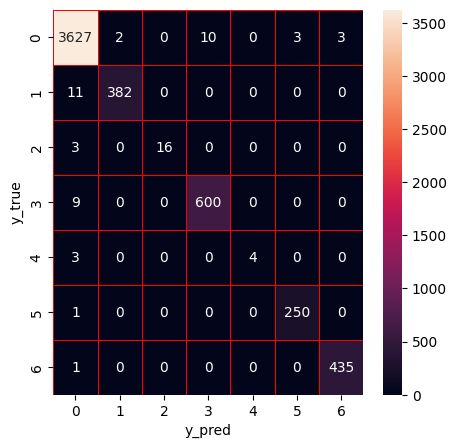

In [99]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_final,y_train)
xg_score=xg.score(X_test_final,y_test)
y_predict=xg.predict(X_test_final)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of XGBoost: 0.9940298507462687
Precision of XGBoost: 0.9940325499970672
Recall of XGBoost: 0.9940298507462687
F1-score of XGBoost: 0.9939948093819071
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       0.99      1.00      1.00       436

    accuracy                           0.99      5360
   macro avg       0.99      0.95      0.97      5360
weighted avg       0.99      0.99      0.99      5360



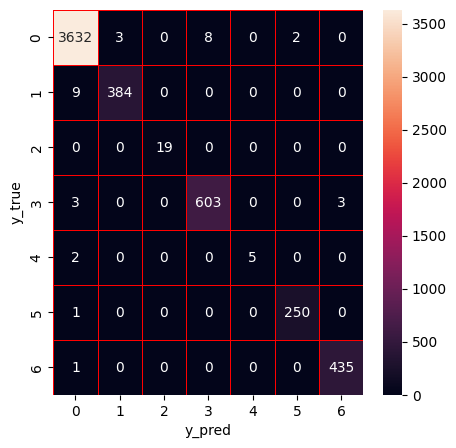

In [16]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_final,y_train)
xg_score=xg.score(X_test_final,y_test)
y_predict=xg.predict(X_test_final)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of XGBoost: 0.991044776119403
Precision of XGBoost: 0.9911226296263477
Recall of XGBoost: 0.991044776119403
F1-score of XGBoost: 0.9909178009537983
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       0.98      0.99      0.98       609
           4       1.00      0.43      0.60         7
           5       0.99      1.00      0.99       251
           6       0.97      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.99      0.91      0.93      5360
weighted avg       0.99      0.99      0.99      5360



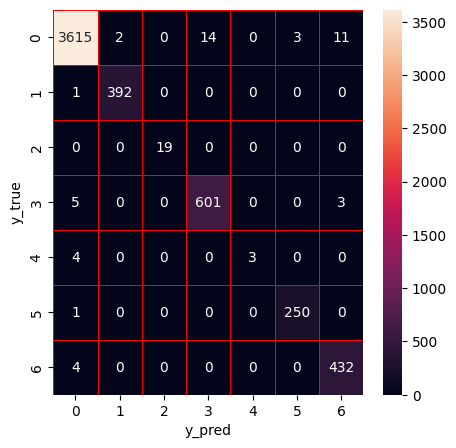

In [23]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train_final,y_train)
xg_score=xg.score(X_test_final,y_test)
y_predict=xg.predict(X_test_final)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Hyperband for Efficient Hyperparameter Optimization:


Hyperband is a novel method for hyperparameter optimization that combines random sampling and elimination to quickly identify promising configurations and allocate more resources to them.

In [17]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.1 MB/s eta 0:00:00


## Apply RF

Accuracy of RF: 0.9958955223880597
Precision of RF: 0.995905600456217
Recall of RF: 0.9958955223880597
F1-score of RF: 0.9958667158915585
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      1.00       436

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



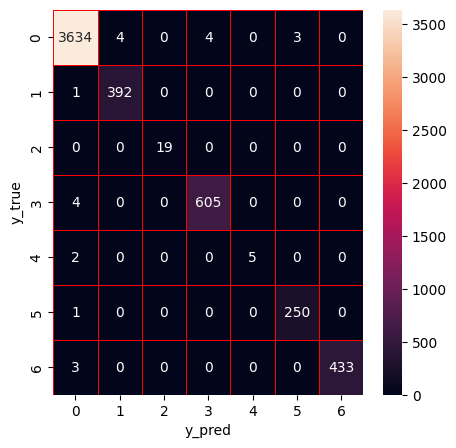

In [15]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_final,y_train)
rf_score=rf.score(X_test_final,y_test)
y_predict=rf.predict(X_test_final)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of RF: 0.9958955223880597
Precision of RF: 0.995905600456217
Recall of RF: 0.9958955223880597
F1-score of RF: 0.9958667158915585
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      1.00       436

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



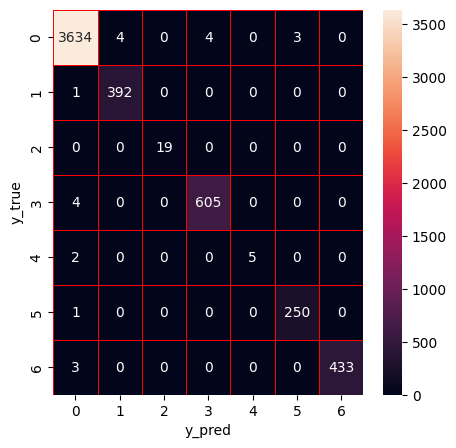

In [17]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train_final,y_train)
rf_score=rf.score(X_test_final,y_test)
y_predict=rf.predict(X_test_final)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [18]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    max_features = trial.suggest_int('max_features', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion
    }

    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train_final, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Random Forest: Optuna estimated optimum hyperparameters:")
print(study.best_params)

[I 2024-05-10 07:42:28,197] A new study created in memory with name: no-name-fcd42c68-af4a-406c-aa07-951316f4cf22
[I 2024-05-10 07:43:30,096] Trial 0 finished with value: 0.9923973880597015 and parameters: {'n_estimators': 123, 'max_depth': 14, 'max_features': 15, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9923973880597015.
[I 2024-05-10 07:44:36,194] Trial 1 finished with value: 0.988526119402985 and parameters: {'n_estimators': 194, 'max_depth': 11, 'max_features': 18, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.9923973880597015.
[I 2024-05-10 07:44:58,770] Trial 2 finished with value: 0.9747201492537313 and parameters: {'n_estimators': 126, 'max_depth': 8, 'max_features': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.9923973880597015.
[I 2024-05-10 07:45:09,002] Trial 3 finished with value: 0.9886194029850746 and p

Random Forest: Optuna estimated optimum hyperparameters:
{'n_estimators': 107, 'max_depth': 25, 'max_features': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}


Accuracy of RF: 0.9970149253731343
Precision of RF: 0.9970229763459072
Recall of RF: 0.9970149253731343
F1-score of RF: 0.9969855634666102
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      1.00       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       1.00      1.00      1.00       436

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



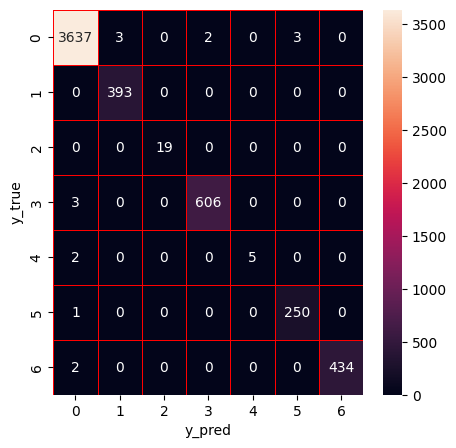

In [19]:
rf_hpo = RandomForestClassifier(n_estimators = 107, min_samples_leaf = 1, max_depth = 24, min_samples_split = 9, max_features = 13, criterion = 'entropy')
rf_hpo.fit(X_train_final,y_train)
rf_score=rf_hpo.score(X_test_final,y_test)
y_predict=rf_hpo.predict(X_test_final)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [21]:
rf_train=rf_hpo.predict(X_train_final)
rf_test=rf_hpo.predict(X_test_final)

In [22]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


## Apply DT

Accuracy of DT: 0.9923507462686567
Precision of DT: 0.9923352636788755
Recall of DT: 0.9923507462686567
F1-score of DT: 0.9923237270079561
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.98      1.00      0.99       393
           2       0.95      1.00      0.97        19
           3       0.99      0.99      0.99       609
           4       0.67      0.57      0.62         7
           5       0.99      1.00      0.99       251
           6       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.94      0.93      0.93      5360
weighted avg       0.99      0.99      0.99      5360



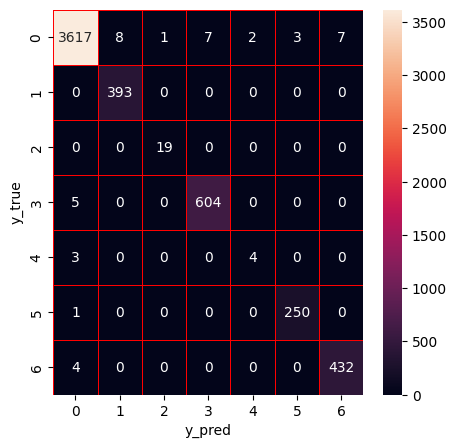

In [75]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train_final,y_train)
dt_score=dt.score(X_test_final,y_test)
y_predict=dt.predict(X_test_final)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of DT: 0.9929104477611941
Precision of DT: 0.9929326683116145
Recall of DT: 0.9929104477611941
F1-score of DT: 0.992915558827126
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3645
           1       0.98      0.99      0.99       393
           2       0.95      1.00      0.97        19
           3       0.99      0.99      0.99       609
           4       0.71      0.71      0.71         7
           5       0.99      1.00      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           0.99      5360
   macro avg       0.94      0.95      0.95      5360
weighted avg       0.99      0.99      0.99      5360



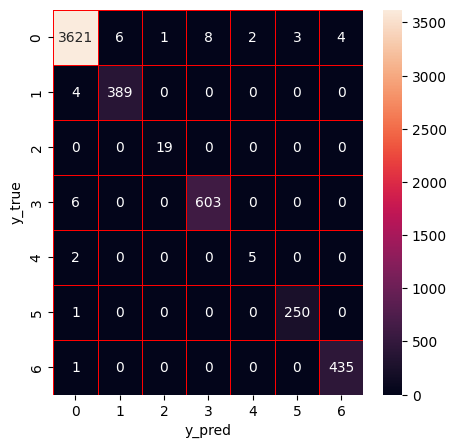

In [23]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train_final,y_train)
dt_score=dt.score(X_test_final,y_test)
y_predict=dt.predict(X_test_final)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [25]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 50)
    max_features = trial.suggest_int('max_features', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    params = {
        'max_depth': max_depth,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion
    }

    clf = DecisionTreeClassifier(**params)
    score = cross_val_score(clf, X_train_final, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Decision Tree: Optuna estimated optimum hyperparameters:")
print(study.best_params)

[I 2024-05-10 07:55:31,330] A new study created in memory with name: no-name-4a7a8044-5f9d-4f38-a26c-9baf812c15ca
[I 2024-05-10 07:55:31,718] Trial 0 finished with value: 0.9884794776119403 and parameters: {'max_depth': 17, 'max_features': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9884794776119403.
[I 2024-05-10 07:55:32,314] Trial 1 finished with value: 0.9868470149253732 and parameters: {'max_depth': 26, 'max_features': 20, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9884794776119403.
[I 2024-05-10 07:55:32,702] Trial 2 finished with value: 0.9444496268656717 and parameters: {'max_depth': 7, 'max_features': 14, 'min_samples_split': 11, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.9884794776119403.
[I 2024-05-10 07:55:33,169] Trial 3 finished with value: 0.9812033582089551 and parameters: {'max_depth': 48, 'max_features': 12, 'min_samp

Decision Tree: Optuna estimated optimum hyperparameters:
{'max_depth': 18, 'max_features': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy'}


Accuracy of DT: 0.9934701492537313
Precision of DT: 0.9934820633911605
Recall of DT: 0.9934701492537313
F1-score of DT: 0.9934703509590384
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      0.95      0.97        19
           3       0.99      0.99      0.99       609
           4       0.71      0.71      0.71         7
           5       0.99      1.00      0.99       251
           6       0.99      1.00      0.99       436

    accuracy                           0.99      5360
   macro avg       0.95      0.95      0.95      5360
weighted avg       0.99      0.99      0.99      5360



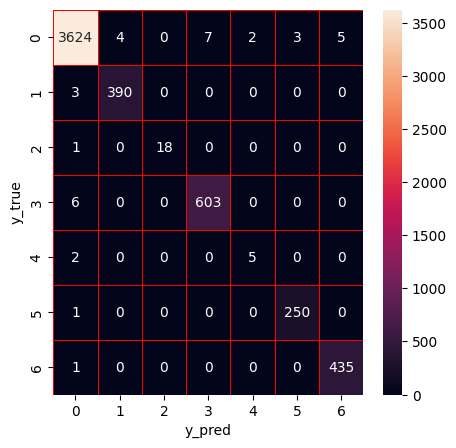

In [33]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 18, min_samples_split = 4, max_features = 30, criterion = 'entropy')
dt_hpo.fit(X_train_final,y_train)
dt_score=dt_hpo.score(X_test_final,y_test)
y_predict=dt_hpo.predict(X_test_final)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [35]:
dt_train=dt_hpo.predict(X_train_final)
dt_test=dt_hpo.predict(X_test_final)

## Apply ET

Accuracy of ET: 0.9942164179104478
Precision of ET: 0.9942268820714036
Recall of ET: 0.9942164179104478
F1-score of ET: 0.9941887984158028
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.95      0.97      5360
weighted avg       0.99      0.99      0.99      5360



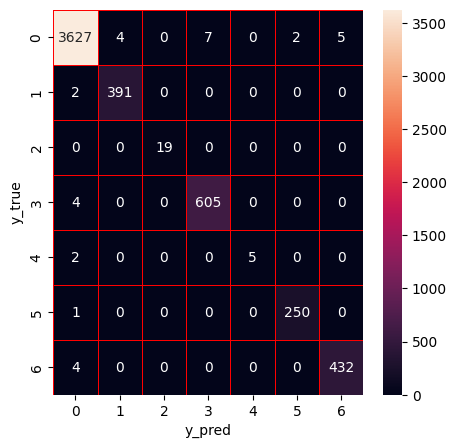

In [79]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train_final,y_train)
et_score=et.score(X_test_final,y_test)
y_predict=et.predict(X_test_final)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of ET: 0.9934701492537313
Precision of ET: 0.9934936993097583
Recall of ET: 0.9934701492537313
F1-score of ET: 0.9934001720288478
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.98      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.57      0.73         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      1.00       436

    accuracy                           0.99      5360
   macro avg       0.99      0.93      0.96      5360
weighted avg       0.99      0.99      0.99      5360



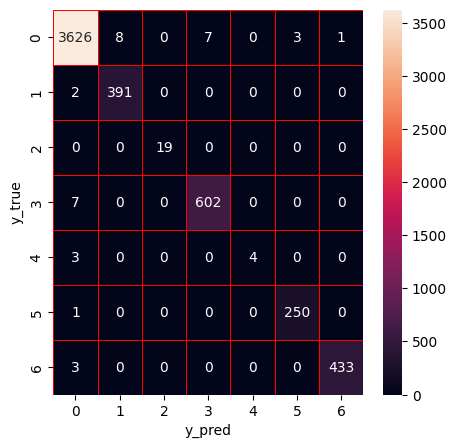

In [36]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train_final,y_train)
et_score=et.score(X_test_final,y_test)
y_predict=et.predict(X_test_final)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [37]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 50)
    max_features = trial.suggest_int('max_features', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 11)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 11)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    params = {
        'max_depth': max_depth,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion
    }

    clf = ExtraTreesClassifier(**params)
    score = cross_val_score(clf, X_train_final, y_train, cv=5, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Random Forest(Extra trees): Optuna estimated optimum hyperparameters:")
print(study.best_params)

[I 2024-05-10 07:59:11,962] A new study created in memory with name: no-name-dc1a728f-5f32-4bb6-93cf-7c7ec51dde98
[I 2024-05-10 07:59:18,696] Trial 0 finished with value: 0.9762126865671641 and parameters: {'max_depth': 39, 'max_features': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.9762126865671641.
[I 2024-05-10 07:59:29,071] Trial 1 finished with value: 0.994356343283582 and parameters: {'max_depth': 37, 'max_features': 11, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.994356343283582.
[I 2024-05-10 07:59:43,324] Trial 2 finished with value: 0.9819496268656716 and parameters: {'max_depth': 26, 'max_features': 20, 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.994356343283582.
[I 2024-05-10 07:59:56,256] Trial 3 finished with value: 0.9624533582089553 and parameters: {'max_depth': 34, 'max_features': 8, 'min_samples_split':

Random Forest(Extra trees): Optuna estimated optimum hyperparameters:
{'max_depth': 39, 'max_features': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}


Accuracy of ET: 0.994589552238806
Precision of ET: 0.994596477836763
Recall of ET: 0.994589552238806
F1-score of ET: 0.994560850156793
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      0.99      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



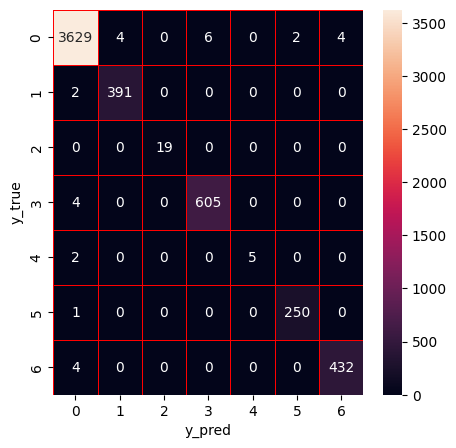

In [82]:
et_hpo = ExtraTreesClassifier( min_samples_leaf = 1, max_depth = 34, min_samples_split = 3, max_features = 13, criterion = 'gini')
et_hpo.fit(X_train_final,y_train)
et_score=et_hpo.score(X_test_final,y_test)
y_predict=et_hpo.predict(X_test_final)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of ET: 0.996268656716418
Precision of ET: 0.9962809018799189
Recall of ET: 0.996268656716418
F1-score of ET: 0.9962399897437341
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      1.00       436

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



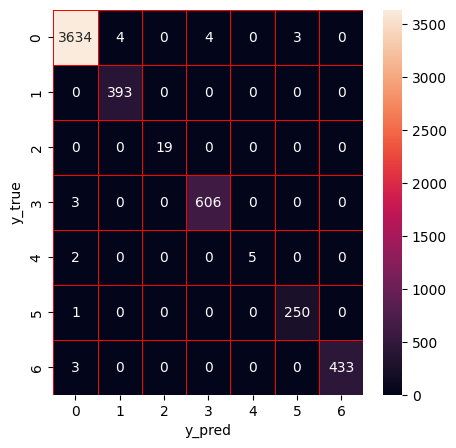

In [39]:
et_hpo = ExtraTreesClassifier( min_samples_leaf = 1, max_depth = 39, min_samples_split = 5, max_features = 30, criterion = 'entropy')
et_hpo.fit(X_train_final,y_train)
et_score=et_hpo.score(X_test_final,y_test)
y_predict=et_hpo.predict(X_test_final)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [41]:
et_train=et_hpo.predict(X_train_final)
et_test=et_hpo.predict(X_test_final)

In [105]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.5 MB/s eta 0:00:00


## Apply Stacking

The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [42]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel()
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees
0,0,0,0
1,0,0,0
2,1,1,1
3,0,0,0
4,3,3,3


In [43]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
# xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
# xg_test=xg_test.reshape(-1, 1)

In [44]:
dt_train.shape

(21440, 1)

In [45]:
x_train = np.concatenate(( dt_train, et_train, rf_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test), axis=1)

Accuracy of Stacking: 0.996268656716418
Precision of Stacking: 0.9962807664284157
Recall of Stacking: 0.996268656716418
F1-score of Stacking: 0.9962403729238578
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       609
           4       1.00      0.71      0.83         7
           5       0.99      1.00      0.99       251
           6       0.99      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



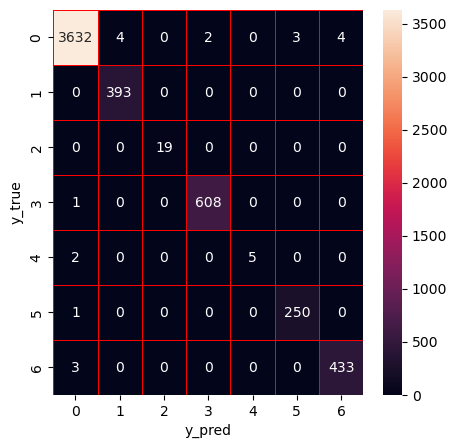

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of Stacking: 0.9958955223880597
Precision of Stacking: 0.9959068447137124
Recall of Stacking: 0.9958955223880597
F1-score of Stacking: 0.9958973352521118
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3645
           1       0.99      1.00      0.99       393
           2       1.00      1.00      1.00        19
           3       0.99      1.00      0.99       609
           4       0.71      0.71      0.71         7
           5       0.99      1.00      0.99       251
           6       1.00      0.99      1.00       436

    accuracy                           1.00      5360
   macro avg       0.95      0.96      0.96      5360
weighted avg       1.00      1.00      1.00      5360



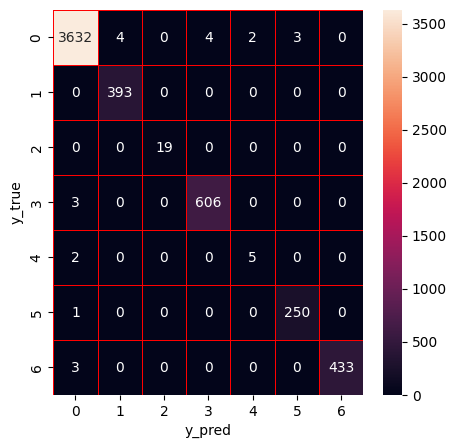

In [46]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.9),
    }
    clf = xgb.XGBClassifier(**params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    return score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("XGBoost: Optuna estimated optimum {}".format(study.best_params))




# import optuna
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# def objective(params):
#     params = {
#         'n_estimators': int(params['n_estimators']),
#         'max_depth': int(params['max_depth']),
#         'learning_rate':  abs(float(params['learning_rate'])),

#     }
#     clf = xgb.XGBClassifier( **params)
#     clf.fit(x_train, y_train)
#     y_pred = clf.predict(x_test)
#     score = accuracy_score(y_test, y_pred)

#     return {'loss':-score, 'status': STATUS_OK }

# space = {
#     'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
#     'max_depth': hp.quniform('max_depth', 4, 100, 1),
#     'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
# }

# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=20)
# print("XGBoost: Hyperopt estimated optimum {}".format(best))

[I 2024-04-29 16:47:50,969] A new study created in memory with name: no-name-1b2a6017-369f-422a-aceb-69787a9ca13f
[I 2024-04-29 16:47:52,932] Trial 0 finished with value: 0.983955223880597 and parameters: {'n_estimators': 55, 'max_depth': 4, 'learning_rate': 0.04452954152526224}. Best is trial 0 with value: 0.983955223880597.
[I 2024-04-29 16:47:59,800] Trial 1 finished with value: 0.994776119402985 and parameters: {'n_estimators': 85, 'max_depth': 99, 'learning_rate': 0.012087215678684532}. Best is trial 1 with value: 0.994776119402985.
[I 2024-04-29 16:48:01,410] Trial 2 finished with value: 0.9951492537313433 and parameters: {'n_estimators': 14, 'max_depth': 32, 'learning_rate': 0.09106498087283976}. Best is trial 2 with value: 0.9951492537313433.
[I 2024-04-29 16:48:03,745] Trial 3 finished with value: 0.996455223880597 and parameters: {'n_estimators': 33, 'max_depth': 10, 'learning_rate': 0.170216031471344}. Best is trial 3 with value: 0.996455223880597.
[I 2024-04-29 16:48:06,129

XGBoost: Optuna estimated optimum {'n_estimators': 53, 'max_depth': 80, 'learning_rate': 0.31146592286625574}


New

In [47]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.9),
    }
    clf = xgb.XGBClassifier(**params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    return score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("XGBoost: Optuna estimated optimum {}".format(study.best_params))

[I 2024-05-10 08:10:20,714] A new study created in memory with name: no-name-01beed3b-d928-4bf9-91d5-7a014fdc4414
<ipython-input-47-e900104db2df>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.9),
[I 2024-05-10 08:10:29,479] Trial 0 finished with value: 0.996268656716418 and parameters: {'n_estimators': 74, 'max_depth': 51, 'learning_rate': 0.07862027146667513}. Best is trial 0 with value: 0.996268656716418.
<ipython-input-47-e900104db2df>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.9),
[I 2024-05-10 08:10:30,692] Trial 1 finishe

XGBoost: Optuna estimated optimum {'n_estimators': 16, 'max_depth': 95, 'learning_rate': 0.7623269963138423}


Accuracy of XGBoost: 0.9975746268656717
Precision of XGBoost: 0.9975780447281358
Recall of XGBoost: 0.9975746268656717
F1-score of XGBoost: 0.9974821551419346
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3655
           1       0.99      1.00      0.99       385
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       605
           4       1.00      0.50      0.67         6
           5       1.00      1.00      1.00       256
           6       1.00      1.00      1.00       434

    accuracy                           1.00      5360
   macro avg       1.00      0.93      0.95      5360
weighted avg       1.00      1.00      1.00      5360



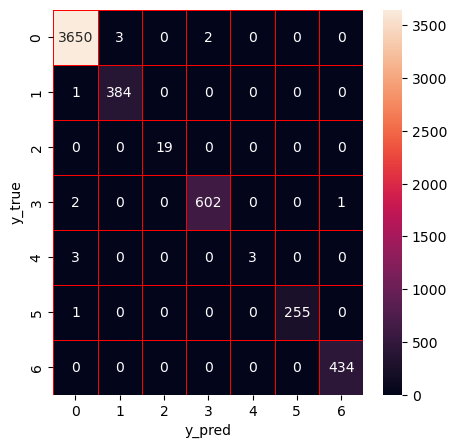

In [ ]:
xg = xgb.XGBClassifier(learning_rate= 0.31146592286625574, n_estimators = 53, max_depth = 80)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

New

Accuracy of XGBoost: 0.9977611940298508
Precision of XGBoost: 0.9977637524166587
Recall of XGBoost: 0.9977611940298508
F1-score of XGBoost: 0.9976686498123707
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3655
           1       0.99      0.99      0.99       385
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00       605
           4       1.00      0.50      0.67         6
           5       1.00      1.00      1.00       256
           6       1.00      1.00      1.00       434

    accuracy                           1.00      5360
   macro avg       1.00      0.93      0.95      5360
weighted avg       1.00      1.00      1.00      5360



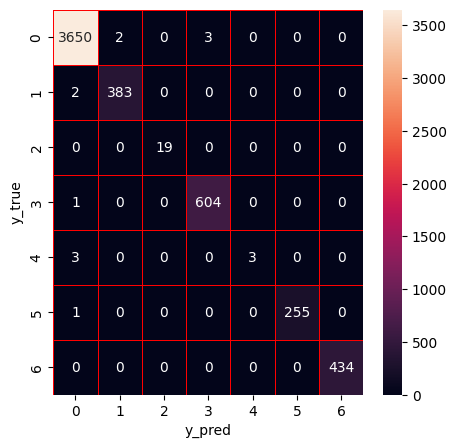

In [50]:
xg = xgb.XGBClassifier(learning_rate= 0.7623269963138423, n_estimators = 60, max_depth = 95)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy: 0.9977611940298508
Precision: 0.9982783883086054
Recall: 0.9268397233124462
F1 Score: 0.9506533494886932
ROC AUC Score: 0.963052826175919


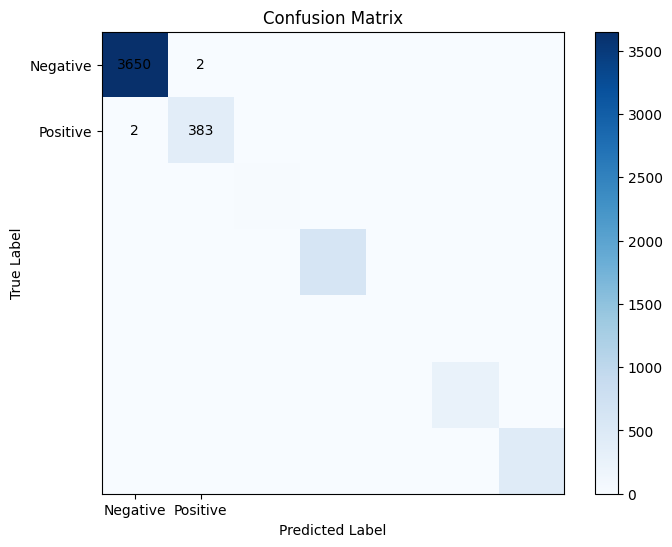

ValueError: multiclass format is not supported

In [54]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


accuracy = accuracy_score(y_true, y_predict)
precision = precision_score(y_true, y_predict, average='macro')
recall = recall_score(y_true, y_predict, average='macro')
f1 = f1_score(y_true, y_predict, average='macro')
roc_auc = roc_auc_score(label_binarize(y_true, classes=np.unique(y)), label_binarize(y_predict, classes=np.unique(y)), average='macro')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_predict)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true,y_predict)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()